# Lecture 6: Accelerating gradient descent with Chebyshev polynomials

[EE227C course page](https://ee227c.github.io/)  
[Download ipynb file](https://ee227c.github.io/code/lecture6.ipynb)

In this lecture we will derive an intriguing way to speed up gradient descent using Chebyshev polynomials. In doing so, we'll also fill in the details for a blog post I wrote four and a half years ago called [zen of gradient descent](http://blog.mrtz.org/2013/09/07/the-zen-of-gradient-descent.html), just in case you were still waiting on that.

Overview:

* [A closer look at quadratics](#quadratics)
* [Connection to polynomial approximation](#polynomials)
* [Chebyshev polynomials](#chebyshev)
* [Accelerated gradient descent for quadratics](#acceleration)

Bibliographic note: *Linear Algebra and its Applications* by Peter D. Lax has a fantastic exposition of this material in Chapter 17. It's generally a fabulous linear algebra text that I highly recommend.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from plotters import kwargs, setup_layout
setup_layout()

<a name="nuclear-norm"></a>

## Quadratics

Consider minimizing the objective function

<p>
$$f(x) = \frac12 x^\top A x - b^\top x$$
</p>

over all of $\mathbb{R}^n,$ where $A\in\mathbb{R}^{n\times n}$ is a symmetric positive definite matrix. We might for instance want to do this when we solve linear equations corresponding to a Laplacian operator. Note that

<p>
$$\nabla f(x) = Ax-b\qquad\text{and}\qquad \nabla^2 f(x) = A.$$
</p>

As we can see, the gradient vanishes when $Ax=b.$
We denote the condition number of the matrix by $\kappa=\beta/\alpha$ where $\beta=\lambda_1(A)$ and $\alpha=\lambda_n(A)>0.$ In particular, we know that the objective function is $\beta$-smooth and $\alpha$-strongly convex.

In [2]:
def quadratic(A, b, x):
    """Quadratic defined by A and b at x."""
    return 0.5 * x.dot(A.dot(x)) - b.dot(x)

We already saw in Lecture 3 that gradient descent achieves a linear convergence rate of the form $\exp(-t\alpha/\beta)$ for all $\alpha$-strongly convex and $\beta$-smooth functions. Let's rederive this result for quadratics, where it's almost trivial.

Let $x^*$ be the unique solution of the linear system $Ax=b$ and put

<p>
$$
e_t = \|x_t-x^*\|
$$
</p>

where $x_{t+1}=x_t - \eta_t (Ax_t-b)$ is defined recursively starting from some $x_0,$ and $\eta_t$ is a step size we'll determine shortly.

Note that $x^*$ satisfies (for any $t$)
<p>
$$
x^* = (I-\eta_t A)x^* +\eta b.
$$
</p>

Hence,
<p>
$$
\begin{align}
e_{t+1} & = x_{t+1}-x^* \\
 & = (I-\eta_t A)x_t +\eta_t b - ( (I-\eta_t A)x^* +\eta_t b ) \\
 & = (I-\eta_t A)e_t.
\end{align}
$$
</p>

This gives us $e_t = p_t(A)e_0,$ where $p_t$ is the polynomial
<p>
$$
p_t(a) = \prod_{i=1}^t (1-\eta_ta)\,.\qquad(*)
$$
</p>

We can upper bound the norm of the error term as

$$
\|e_t\|\le \|p_t(A)\|\cdot\|e_0\|\,.
$$

Since $A$ is a symmetric matrix with eigenvalues in $[\alpha,\beta],$ it's not hard to justify that

<p>
$$
\|p_t(A)\|\le \max_{\alpha\le a\le\beta} \left|p_t(a)\right|\,.
$$
</p>

This leads to an intriguing problem: Among all polynomials that satisfy $p_t(0)=1$ we're looking for a polynomial whose magnitude is as small as possible in the interval $[\alpha,\beta].$

<a name="polynomials"></a>

## The naive polynomial solution

A naive solution is to choose a uniform step size $\eta_t=2/(\alpha+\beta)$ in the expression $(*).$ This rescales the eigenvalues of $A$ just in the right way so that a simple calculation gives the bound:

<p>
$$
\|e_t\|\le \left(1-\frac1{\kappa}\right)^t\|e_1\|
\le \exp\left(-\alpha t/\beta\right)\|x_0-x^*\|\,.
$$
</p>

This is exactly the rate we proved in Lecture 3 for any smooth and strongly convex function. So, no surprise yet.

Let's look at this polynomial a bit closer. In the example below we choose $\alpha=1$ and $\beta=10$ so that $\kappa=10.$ The relevant interval is therefore $[1,10].$

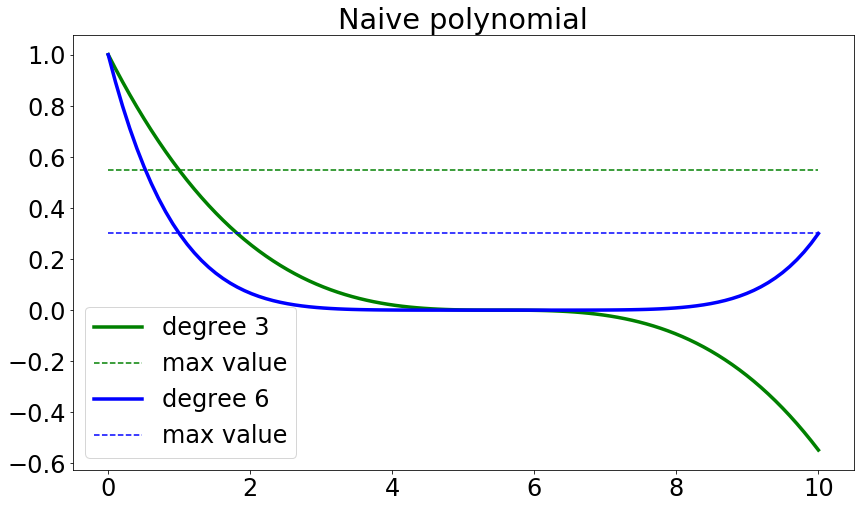

In [3]:
def p(k, x, alpha=1.0, beta=10.0):
    return np.power(1.0 - 2.0*x/(alpha+beta), k)

alpha, beta = 1.0, 10.0
xs = np.linspace(0, beta, 100)
plt.figure(figsize=(14, 8))
plt.title('Naive polynomial')
plt.plot(xs, p(3, xs), 'g-', label='degree 3', **kwargs)
plt.plot(xs, [p(3, alpha)]*len(xs), 'g--', label='max value')
plt.plot(xs, p(6, xs), 'b-', label='degree 6', **kwargs)
plt.plot(xs, [p(6, alpha)]*len(xs), 'b--', label='max value')
_ = plt.legend()

Doubling the degree roughly halves the maximum absolute value that the polynomial attains in the interval $[\alpha, \beta].$

Can we do better than this? Surprisingly, the answer is yes!

<a name="chebyshev"></a>

## Chebyshev polynomials

Chebyshev polynomials turn out to give an optimal answer to the question that we asked. Suitably rescaled, they minimize the absolute value in a desired interval $[\alpha, \beta]$ while satisfying the normalization constraint of having value $1$ at the origin.

Before we do the rescaling, we will first look at the standard Chebyshev polynomials ("of the first kind") on the interval $[-1,1].$ These polynomials have several natural equivalent definitions. We define the Chebyshev polynomial $T_k$ recursively as follows:

<p>
$$
\begin{align}
T_0(a) &= 0\\
T_1(a) &= x\\
T_k(a) &=2aT_{k-1}(a)-T_{k-2}(a),\qquad k\ge 2.\\
\end{align}
$$
</p>

In [4]:
def T(k, a):
    """Chebyshev polynomial of degree k"""
    if k <= 1:
        return a**k
    else:
        return 2.0*a*T(k-1, a) - T(k-2, a)

Here are the first 5 Chebyshev polynomials.

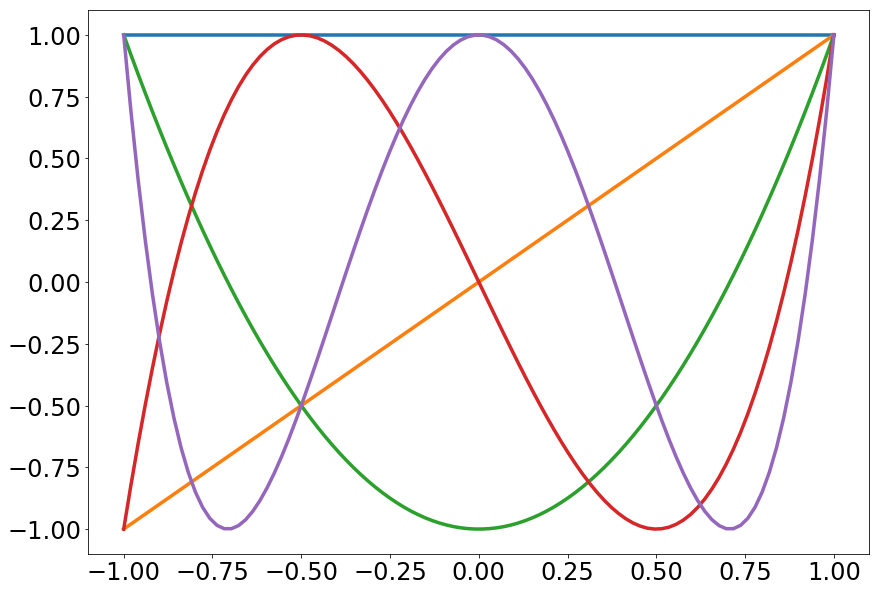

In [5]:
xs = np.linspace(-1, 1, 100)
plt.figure(figsize=(14, 10))
_ = [plt.plot(xs, T(k, xs), **kwargs) for k in range(0, 5)]

So far so good. The magic happens when we rescale these polynomials so as to satisfy our requirements.

### Rescaled Chebyshev polynomials

Recall that the eigenvalues of the matrix we consider are in the interval $[\alpha, \beta].$ We need to rescale the Chebyshev polynomials so that they're supported on this interval and still attain value $1$ at the origin. This is accomplished by the polynomial

<p>
$$
P_k(a) = T_k\left(\frac{\beta+\alpha-2a}{\beta-\alpha}\right)\cdot T\left(\frac{\beta+\alpha}{\beta-\alpha}\right)^{-1}\,.
$$
</p>

In [6]:
def P(k, a, alpha=1, beta=10.0):
    """Rescaled Chebyshev polynomial."""
    assert beta > alpha
    normalization = T(k, (beta+alpha)/(beta-alpha))
    return T(k, (beta+alpha-2*a)/(beta-alpha))/normalization

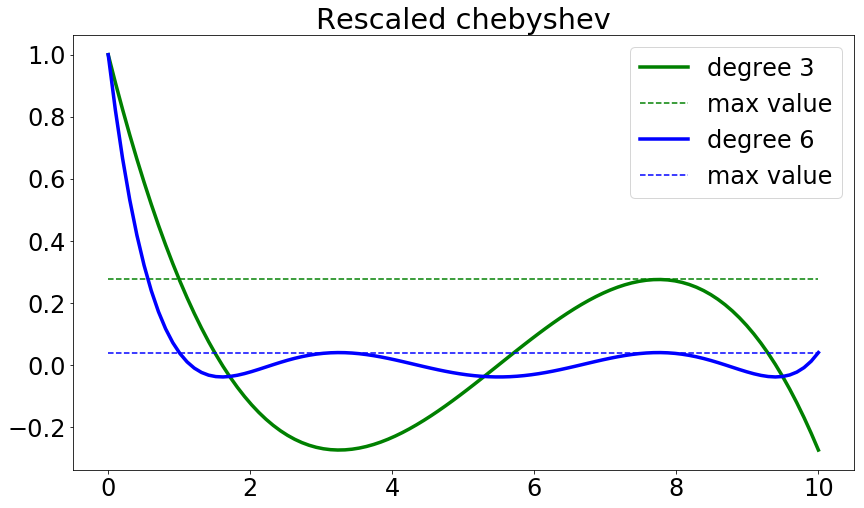

In [7]:
alpha, beta = 1.0, 10.0
xs = np.linspace(0, beta, 100)
plt.figure(figsize=(14, 8))
plt.title('Rescaled chebyshev')
plt.plot(xs, P(3, xs), 'g-', label='degree 3', **kwargs)
plt.plot(xs, [P(3, alpha)]*len(xs), 'g--', label='max value')
plt.plot(xs, P(6, xs), 'b-', label='degree 6', **kwargs)
plt.plot(xs, [P(6, alpha)]*len(xs), 'b--', label='max value')
_ = plt.legend()

We see that doubling the degree has a much more dramatic effect on the magnitude of the polynomial in the interval $[\alpha, \beta].$

Let's compare this beautiful Chebyshev polynomial side by side with the naive polynomial we saw earlier.

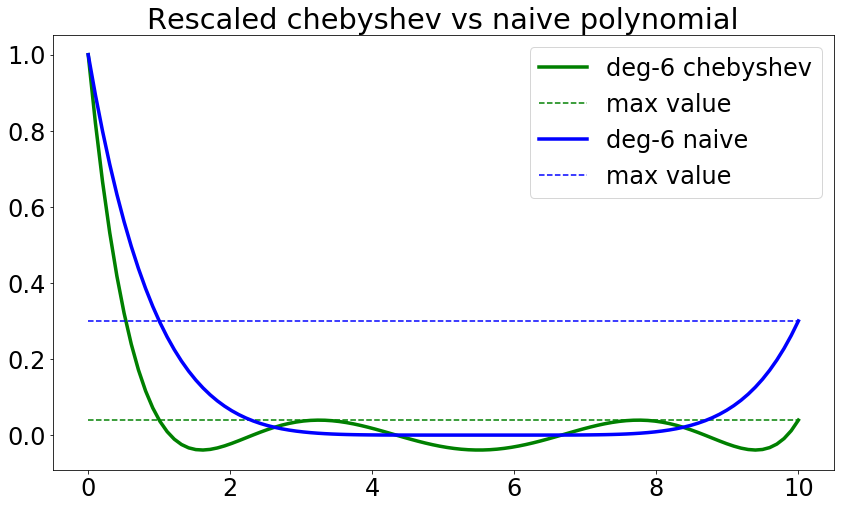

In [8]:
plt.figure(figsize=(14, 8))
plt.title('Rescaled chebyshev vs naive polynomial')
plt.plot(xs, P(6, xs), 'g-', label='deg-6 chebyshev', **kwargs)
plt.plot(xs, [P(6, alpha)]*len(xs), 'g--', label='max value')
plt.plot(xs, p(6, xs), 'b-', label='deg-6 naive', **kwargs)
plt.plot(xs, [p(6, alpha)]*len(xs), 'b--', label='max value')
plt.legend()

That looks promising. But what exactly is the error bound that comes out of it and how does it lead to an iterative algorithm? These are important questions that we'll answer next.

<a name="acceleration"></a>

## Accelerated gradient descent

The Chebyshev polynomial leads to an accelerated version of gradient descent. Before we describe the iterative process, let's first see what error bound comes out of the Chebyshev polynomial.

So, just how large is the polynomial in the interval $[\alpha, \beta]$? First, note that the maximum value is attained at $\alpha$. Plugging this into the definition of the rescaled Chebyshev polynomial we get the upper bound for any $a\in[\alpha, \beta],$

<p>
$$
|P_k(a)| \le P_k(\alpha)= T\left(\frac{\beta+\alpha}{\beta-\alpha}\right)^{-1}.
$$
</p>

Recalling the condition number $\kappa=\beta/\alpha,$ we have
<p>
$$
\frac{\beta+\alpha}{\beta-\alpha}
=\frac{\kappa+1}{\kappa-1}=1+\epsilon
$$
for some $\epsilon\approx 2/\kappa.$
</p>

We therefore only need to understand the value of $T_k$ at $1+\epsilon.$

A well-known fact about the Chebyshev polynomials comes in handy.

**Fact**. For $x>1,$ we have $T_k(x)=\cosh(k\cdot\mathrm{arccosh}(x)).$

Recall that $\cosh(x) = (e^x+e^{-x})/2$ and $\mathrm{arccosh}(x) = \ln(x+\sqrt{x^2-1}).$


Now, letting $\phi=\mathrm{arccosh}(1+\epsilon),$
<p>
$$
e^{\phi} = 1+\epsilon+\sqrt{2\epsilon+\epsilon^2}
\ge 1+\sqrt{\epsilon}\,.
$$
</p>

Therefore,
<p>
$$
T_k(1+\epsilon)=\frac{(e^{\phi})^k+(e^{\phi})^{-k}}{2}
\ge \frac{\big(1+\sqrt{\epsilon}\big)^k}2\,.
$$
</p>

The reciprocal is what we needed to upper bound, so we have
<p>
$$
T\left(\frac{\beta+\alpha}{\beta-\alpha}\right)^{-1}
\le 2\big(1+\sqrt{\epsilon}\big)^{-k}\,.
$$
</p>

This establishes that the Chebyshev polynomial achieves the error bound
<p>
$$
\|e_k\|\le 2\big(1+\sqrt{\epsilon}\big)^{-k}\|e_0\|
$$
</p>

Recalling that $\epsilon\approx 1/\kappa,$ this means that for large $\kappa,$ we get quadratic savings in the degree we need before the error drops of exponentially.

### The Chebyshev recurrence relation

Due to the recursive definition of the Chebyshev polynomial, we directly get an iterative algorithm out of it. Transferring the recursive definition to our rescaled Chebyshev polynomial, we have

<p>
$$
P_{k+1}(a) = (\eta_k a + \gamma_k)P_k(a) + \mu_k P_{k-1}(a),
$$
</p>

where we can work out the coefficients $\eta_k,\gamma_k,\mu_k$ from the definition. Since $P_k(0)=1,$ we must have $\gamma_k+\mu_k=1.$ This leads to a simple update rule for our iterates:

<p>
$$
\begin{align}
x_{k+1} &= (\eta_k A + \gamma_k)x_k + (1-\gamma_k) x_{k-1}-\eta_k b\\
&= x_k - \eta_k\nabla f(x_k) + \mu_k (x_k - x_{k-1})
\end{align}
$$
</p>

We see that this update form is very similar to plain gradient descent except for the additional term $\mu_k(x_k - x_{k-1}).$ This term can be interpreted as a *momentum* term, pushing the algorithm in the direction of where it was headed before.

In the next lecture, we'll dig deaper into momentum and see how to generalize the result for quadratics to general convex functions.

## That's it. Thanks.